# Analyze A-B Test Results

## Table of Contents
- **Introduction**

- **Part I - Probability:** Statistics were computed to find out the probabilities of converting regardless of page. These were used to analyze if one page or the other led to more conversions.

- **Part II - A/B Test:** Next, hypothesis testing was conducted assuming the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The data was bootstrapped and sampling distributions were determined for both pages. Conclusions were drawn on conversions for both pages by calculating p-values.

- **Part III - Regression:** Logistic regression was then performed to confirm results of the previous steps. Null and alternative hypotheses associated with this regression model were stated and verified using statsmodel.


## Intorduction
For this project, you will be working to understand the results of an A/B test run by an e-commerce website.The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. dataset reflecting data collected from an experiment. Use statistical techniques to answer questions about the data and report your conclusions and recommendations in a report.

## Part I - Probability

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)

In [3]:
# Import Data
df = pd.read_csv('ab_data.csv',                
                 parse_dates = ["timestamp"])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Use the below cell to find the number of rows in the dataset.**

In [4]:
df.shape

(294478, 5)

In [5]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


As we see the proportions od user converted is 0.119659

**The number of unique users in the dataset.**

In [6]:
df.value_counts().sum()

294478

In [7]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**The number of times the new_page and treatment don't line up.**

In [8]:
df.query('group == "treatment" and landing_page != "new_page"')

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


In [9]:
df.query('group == "control" and landing_page!= "old_page"')

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


**Do any the rows have missing values?**

In [10]:
# check if any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


**For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page**

**create a new dataset.**

In [11]:
# put all treatment AND new_page into one dataframe
df2t= df.query('group == "treatment" and landing_page == "new_page"')

In [12]:
# put all control AND old_page into one dataframe
df2c= df.query('group == "control" and landing_page=="old_page"')

In [13]:
# merge two properly aligned dataframes together
df2 = df2t.merge(df2c, how='outer')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [14]:
df2.shape

(290585, 5)

In [15]:
df2.describe()

,user_id,converted
count,290585.000000,290585.000000
mean,788004.825246,0.119597
std,91224.582639,0.324490
min,630000.000000,0.000000
25%,709035.000000,0.000000
50%,787995.000000,0.000000
75%,866956.000000,0.000000
max,945999.000000,1.000000


In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))==False].shape[0]

0

**How many unique user_ids are in df2?**

In [17]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

290584 user_id, 290585 timestamp

**There is one user_id repeated in df2. What is it?**

In [18]:
print(f'The user_id reapeted reocrds id is {df2.user_id.duplicated().sum()}')

The user_id reapeted reocrds id is 1


**What is the row information for the repeat user_id?**

In [19]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**Remove one of the rows with a duplicate user_id.**

In [20]:
#using a bitwise (~) operation on a DataFrame
df2 = df2[~df2['user_id'].duplicated(keep='first')]
# https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries

In [21]:
df2.shape

(290584, 5)

**What is the probability of an individual converting regardless of the page they receive?**

In [22]:
df2.converted.mean()

0.11959708724499628

**Given that an individual was in the `control` group, what is the probability they converted?**

In [23]:
df2_control = df2[df2['group'] == 'control']

or

In [24]:
df2_control = df2.query('group =="control"')
df2_control.converted.mean()

0.1203863045004612

**Given that an individual was in the `treatment` group, what is the probability they converted?**



In [25]:
df2_treatment = df2.query('group == "treatment"')
df2_treatment.converted.mean()

0.11880806551510564

**What is the probability that an individual received the `new_page`?**



In [26]:
len(df2_control.index)/len(df2.index)

0.4999380557773312

In [27]:
len(df2_treatment.index)/len(df2.index)

0.5000619442226688

**Answer:** It appears that individuals in the `treatment` group had a conversion rate of 11.88% and individuals in the `control` grounp had a conversion rate of 12.04%. This leads us to think that the `treatment` group does not lead to more conversions than the `control` group. However, it remains to be seen if this is true, or due to some bias.

## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.

**ANSWER:** If we assume the old page is better unless the new page proves to be definately better, then the null hypotheses is that the mean converted rate of the old page is greater or equal to the converted rate of the new page and the alternative hypothesis is that the mean converted rate of the new page is greater than the converted rate of the old page.

Null Hypotheses: $p_{old}$ is greater or equal to $p_{new}$

Alternative Hypothesis: $p_{old}$ is less than $p_{new}$

2. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.


a. What is the `convert` rate for $p_{new}$ under the null?

$p_{new}$ = df2.converted.mean() = 0.11959708724499628

b. What is the `convert` rate for $p_{old}$ under the null?


$p_{old}$ = df2.converted.mean() = 0.11959708724499628



**What is $n_{new}$?**



In [28]:
n_new = len(df2_treatment.index)
n_new

145310

**What is $n_{old}$?**

In [29]:
n_old = len(df2_control.index)
n_old

145274

**What is the convert rate for $p_{new}$ under the null?**

In [30]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**What is the convert rate for $p_{old}$ under the null?**

In [31]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in new_page_converted.**


**Note:**
> * Below few cells will see alternative method, please run both of those in two different runs. They both give different results!
> * As a matter of fact they should not.
> * The difference will be visible in the histogram and in p-value

In [32]:
# Null simulating n_new transaction that have probabiliy of receiving new page, 
# using binomial gives the outout as the number of 1's
new_page_converted = np.random.binomial(1,p_new, n_new)
new_page_converted.mean()

0.12081068061386002

In [33]:
# alternatively
new_converted_simulation = np.random.binomial(n_new, p_new,10000)/n_new
new_converted_simulation.mean()

0.11958485995457986

**Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in old_page_converted**

In [34]:
# Null simulating n_old transaction that have probabiliy of receiving old page, 
# using binomial gives the outout as the number of 1's
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.1196291146385451

In [35]:
# alternatively
old_converted_simulation = np.random.binomial(n_old, p_old,10000)/n_old
old_converted_simulation.mean()

0.11960182689263046

**Find $p_{new}$ - $p_{old}$ for your simulated values**

In [36]:
# (Null)probabilty of new and old page based upon simulated values.
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_new - p_old


0.0011815659753149216

In [37]:
# alternatively
new_converted_simulation.mean() - old_converted_simulation.mean()

-1.6966938050602676e-05

**Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated in parts a. through g. above. Store all 10,000 values in p_diffs.**

In [38]:
# Create a sampling distribution of the difference in proportions
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new) # bootstrapping
    old_page_converted = np.random.binomial(1,p_old,n_old) # bootstrapping
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [39]:
# alternatively
p_diffs_alt = new_converted_simulation - old_converted_simulation
p_diffs_alt

array([-0.00210139,  0.00114698, -0.00091064, ...,  0.00029365,
       -0.00135758, -0.00017405])

**Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.**

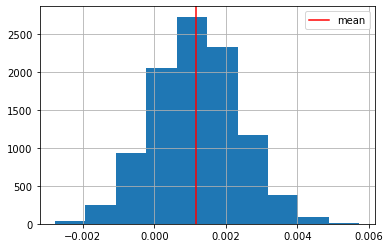

In [40]:
# convert p_diffs to numpy array for array based computations in the future
p_diffs = np.array(p_diffs)

# histogram
plt.hist(p_diffs)
plt.grid()
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend();

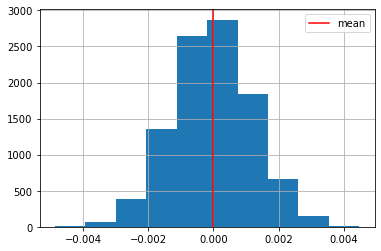

In [41]:
# alternatively
plt.hist(p_diffs_alt)
plt.grid()
plt.axvline(p_diffs_alt.mean(), color='r', label='mean')
plt.legend();

**A faster way to simulate the 10000 trials** Require Changes

When possible, it is always more computationally efficient to use numpy built-in operations over explicit for loops. The short reason is that numpy-based operations attack a computational problem based on vectors by computing large chunks simultaneously.



Additionally, using loops to simulate 10000 can take a considerable amount of time vs using numpy https://softwareengineering.stackexchange.com/questions/254475/how-do-i-move-away-from-the-for-loop-school-of-thought


new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new


old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 


p_diffs = new_converted_simulation - old_converted_simulation

When we divide it by n_new, Python broadcasts n_new for each element and we return a proportion for each element.


This is essentially is simulating, 10000, the new page conversion rate.

We do this again for the old page.


The difference of the two will result in a simulated difference array of length 10000 between the new page and old page conversions.


Note that this method does not require you to calculate the null values to get the p-value.



**What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?**

In [42]:
# Null
actual_diff = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(actual_diff < p_diffs).mean()

0.9901

In [43]:
# alternatively
actual_diff_alt = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(actual_diff_alt < p_diffs_alt).mean()

0.9031

**In words, explain what you just computed in part this part. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?**

* What we computed in part this part. is called p-value in scientific studies
* p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
* In our case the p-value is big that we can confidently say that we fail to reject null hypothesis

**We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.**

In [44]:
# quick check before diving in
df2.head(10)

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
5,929503,2017-01-18 05:37:11.527370,treatment,new_page,0
6,834487,2017-01-21 22:37:47.774891,treatment,new_page,0
7,803683,2017-01-09 06:05:16.222706,treatment,new_page,0
8,944475,2017-01-22 01:31:09.573836,treatment,new_page,0
9,718956,2017-01-22 11:45:11.327945,treatment,new_page,0


In [45]:
import statsmodels.api as sm

convert_new = df2.converted[df2.group == 'treatment'].sum()
convert_old = df2.converted[df2.group == 'control'].sum()
n_new = df2[df2.group == 'treatment'].converted.count()
n_old = df2[df2.group == 'control'].converted.count()

**Now use stats.proportions_ztest to compute your test statistic and p-value.**

we have all the values required. However, it is worth noticing that the argument alternative in the function is 'two-sided' by default. But our hypothesis is not designed around 'either-or' scenario at this point. Therefore, the argument alternative will be 'smaller', meaning one-tailed experiment

In [46]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

**What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?**

* A z-score represents how many standard deviations away our data point is from the mean
* A positive z-score suggests that our data point is on the right side of the mean line on the bell curve
* p-value of 0.9050 is very close to the p-value we computed earlier
* With this computation, we can confidently say we fail to reject null hypothesis

## Part III - A regression approach

**In this final part, will see that the result that acheived in the previous A/B test can also be acheived by performing regression.**

**Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?**

The dependent variable is a binary variable (converted vs not converted). Thus, you need to use a logistic regression.
we want to predict something that has only two possible outcomes

**The goal is to use statsmodels to fit the regression model you specified in the last part. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control**

In [47]:
# quick consistency check
df2.head(10)

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
5,929503,2017-01-18 05:37:11.527370,treatment,new_page,0
6,834487,2017-01-21 22:37:47.774891,treatment,new_page,0
7,803683,2017-01-09 06:05:16.222706,treatment,new_page,0
8,944475,2017-01-22 01:31:09.573836,treatment,new_page,0
9,718956,2017-01-22 11:45:11.327945,treatment,new_page,0


In [59]:
# copy the dataframe to a new one, for clarity
df2_copy = df2.copy()

In [60]:
# another sanity check, if True, go ahead
df2_copy.shape == df2.shape

True

In [61]:
# add an intercept
df2_copy['intercept'] = 1

df2_copy[['landing_page_new', 'landing_page_old']] = pd.get_dummies(df2_copy['landing_page'])
df2_copy[['ab_page_control','ab_page_treatment']] = pd.get_dummies(df2_copy['group'])


In [62]:
# here, we will use landing_page_old and ab_page_control as our baselines, therefore remove those
df2_copy.drop(['ab_page_control','landing_page_old'], axis=1, inplace=True)

In [66]:
df2_copy.head(-10)

,user_id,timestamp,group,landing_page,converted,intercept,landing_page_new,ab_page_treatment
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1
...,...,...,...,...,...,...,...,...
290570,927527,2017-01-12 10:52:11.084740,control,old_page,0,1,0,0
290571,789177,2017-01-17 18:17:56.215378,control,old_page,0,1,0,0
290572,924816,2017-01-20 10:59:03.481635,control,old_page,0,1,0,0
290573,740310,2017-01-10 17:22:19.762612,control,old_page,0,1,0,0


**Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns that created in the last part. to predict whether or not an individual converts.**

In [65]:
logit_mode = sm.Logit(df2_copy['converted'], df2_copy[['intercept', 'ab_page_treatment']])
results = logit_mode.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**Provide the summary of your model below, and use it as necessary to answer the following questions.**

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        17:38:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007
=====================================================================================
"""

In [70]:
# interprete the coefficients
1/np.exp(results.params[1])

#Note: exp(x) = e^x where e= 2.718281(approx)

1.0151020136964783

In [71]:
# additional: question posed by previous reviewer
# how to get p-value as if it were a one-tailed test
1-0.190/2

0.905

For each 1 unit decrease in ab_page_treatment, conversion is 1.015 time likely holding all the other variables constant. Which is not really why we would launch a new_page!

**What is the p-value associated with ab_page? Why does it differ from the value you found in the Part II?**


**Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the Part II?

The p-value associated with ab_page is 0.190. It is higher than 0.05. Thus, the coefficient is not significant.
- As we already built the base for z-score and p-value in part II, this p-value is different of course.
- The logistic regression is two-tailed case. We are exploring only two possible outcomes and it can go either way.
- Interesting part to observe is z-score, absolute of which confirms the number in part II.

The null and alternative hypothesis associated with regression model will be as following:
$$ H_{0}: p_{old} - p_{new} = 0$$$$ H_{0}: p_{old} - p_{new} \neq 0$$



In [81]:
# duration of the experiment
duration = np.array(df.timestamp.sort_values(ascending=True))
td = duration[-1] - duration[0]

days = td.astype('timedelta64[D]')
days / np.timedelta64(1,'D')

21.0

**Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?**

There can be many other factors that can be taken into consideration to add into our regression model.

- One of the first to consider would be the duration. The duration of this experiment was 21 days. Too short, it would be advisable to increase the duration
- Geographic location is another important factor. If the page is available in multiple languages, for example, it can diversify the sample
- Parameters like click through rate is another factor to consider


**Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows. Here are the docs for joining tables.**


**Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy varaibles. Provide the statistical output as well as a written response to answer this question.**

In [88]:
# read file and join the dfs
country_df = pd.read_csv('countries.csv')
df_new = country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0
...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0


In [90]:
# Create the necessary dummy variables
df_new[['canada','uk', 'us']] = pd.get_dummies(df_new['country'])
df_new

,country,timestamp,group,landing_page,converted,canada,uk,us
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0
...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,0,1,0


In [93]:
# let's consider US being our baseline, therefore, we drop US
df_new.drop(['us'], axis=1, inplace= True)
df_new

,country,timestamp,group,landing_page,converted,canada,uk
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1
...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,0,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,0,1
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,0,1


**Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model**

Provide the summary results, and your conclusions based on the results.


In [94]:
# fitting linear model
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','canada','uk']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [95]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 26 Aug 2021   Pseudo R-squ.:               1.521e-05
Time:                        18:49:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
canada        -0.0408      0.027     -1.518      0.129      -0.093       0.012
uk             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [97]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Above results can be read as:

- users from uk are 1.009 times more likely to convert as compared to users from us
- users from canada are 1.042 times more likely to less convert as compared to users from us


## Conclusions
Within the framework this project, we tried to understand whether the company should implement a new page or keep the old page with following:

- Probability based approach
- A/B test
- Regression approach


**Probability based approach:**
- We found that probability of an individual receiving the new page is 0.5001
- Meaning, there is almost the same chance that an individual received the old page

**A/B test:**
- In A/B test we set up our hypothesis to test if new page results in better conversion or not
- We simulated our user groups with respect to conversions
- We found the p_value to be 0.9050583127590245
- With such a p-value, we accept null hypothesis
- By using the built-in stats.proportions_ztest we computed z-score and p-value which confirmed our earlier p-value and failure to reject null hypothesis

**Regression Approach:**
- We looked at exploring two possible outcomes. Whether new page is better or not.
- With logistic regression results, we again encountered same z-score as well as p-value of 0.190, corresponding two-tailed case
- By further adding geographic location of the users, we tried to find if any specific country had an impact on conversion
- The result gave a similar outlook and suggested that the countries have no impact on the conversion rate.

**Consideration:**
- We also looked at the duration of the experiment (21 days).
- This is a relatively short period of time to run the A/B test.
- Due to Change aversion effect, a group of users may give an unfair advantage to the older page
- Similarly, due to Novelty effect, users may give an unfair advantage to the newer page
